In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
from sklearn.metrics import accuracy_score

import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # fix error on MAC_OS when using light gbm, xgboost
from sklearn.metrics import mean_squared_error

import lightgbm
sns.set(style='white', context='notebook', palette='deep')


## read input

with open('./data/X.pickle', 'rb') as handle:
    X = pickle.load(handle)
    
with open('./data/y.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [2]:
X.head()

,Age,Fare,Parch,Sex,SibSp,Fsize,Single,SmallF,MedF,LargeF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [3]:
print(Counter(y))
y[:5]

Counter({0: 413, 1: 268, 2: 200})


0    2
1    2
2    1
3    1
4    0
Name: value, dtype: int64

## 1. objective="multiclass"

In [4]:

num_trees = 1
max_depth_tree  = 1

multiclass_model = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=max_depth_tree,
        min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
        n_estimators=num_trees, n_jobs=-1, num_leaves=31, metric= "multi_error" ,objective="multiclass",num_class =3,
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

multiclass_model.fit(X, y, verbose=1, eval_set=  [(X, y)], eval_names= ['train'])

[1]	train's multi_error: 0.38933


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=1,
        metric='multi_error', min_child_samples=1, min_child_weight=0,
        min_split_gain=0.0, n_estimators=1, n_jobs=-1, num_class=3,
        num_leaves=31, objective='multiclass', random_state=1,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

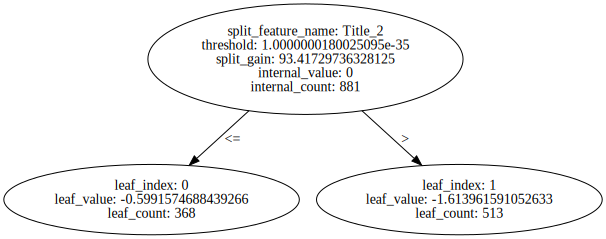

In [5]:
lightgbm.create_tree_digraph(multiclass_model, tree_index=1, show_info=["split_gain",
                                                  "internal_value", "internal_count", "leaf_count"])

## 2. objective="multiclassova"

In [6]:
mutilclassova_model = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=max_depth_tree,
        min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
        n_estimators=num_trees, n_jobs=-1, num_leaves=31, metric= "multi_error" ,objective="multiclassova",num_class =3,
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

mutilclassova_model.fit(X, y, verbose=1, eval_set=  [(X, y)], eval_names= ['train'])


[1]	train's multi_error: 0.38933


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=1,
        metric='multi_error', min_child_samples=1, min_child_weight=0,
        min_split_gain=0.0, n_estimators=1, n_jobs=-1, num_class=3,
        num_leaves=31, objective='multiclassova', random_state=1,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

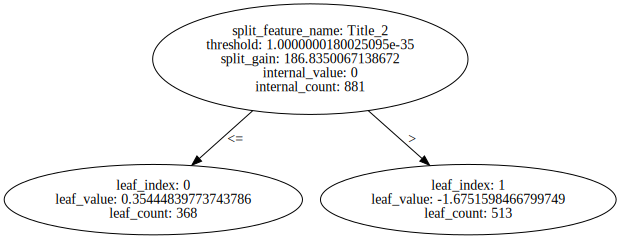

In [7]:
lightgbm.create_tree_digraph(mutilclassova_model, tree_index=1 ,  show_info=["split_gain", "internal_value", "internal_count", "leaf_count"])

## 3. objective="binary"

In [8]:
## keep the class 1 the same, merge class 0 and 2 to class "Not 1" (i.e., class 0)
y[y == 2]= 0
Counter(y)

Counter({0: 613, 1: 268})

In [9]:
binary_model = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=max_depth_tree,
        min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
        n_estimators=num_trees, n_jobs=-1, num_leaves=31, metric= "error", objective="binary",
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

binary_model.fit(X, y, verbose=1, eval_set=  [(X, y)], eval_names= ['train'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=1,
        metric='error', min_child_samples=1, min_child_weight=0,
        min_split_gain=0.0, n_estimators=1, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=1, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

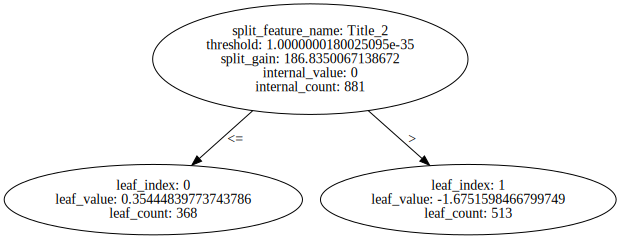

In [10]:
lightgbm.create_tree_digraph(binary_model, tree_index=0,  show_info=["split_gain", "internal_value", "internal_count", "leaf_count"])


# Question

Consider the first tree for class 1, I see that:

**binary_model** returns the same tree compared to **mutilclassova_model** as I expected. However, the **mutilclass_model** returns different tree (different raw scores). 

So, I can understand how **mutilclassova_model** works. In terms of **mutilclass_model**, I know it uses *softmax* instead of *sigmoid* function but if it's ONLY the difference, the 2 trees should still to be the same, not different like that. I really don't know how **mutilclass_model** works ?

Can you help me out with this.

Thanks.